In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_scores(y_test, y_pred):
    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    #print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    print('R2:  ', r2_score(y_test, y_pred))
    print('VAR:  ', np.var(y_test))

In [9]:
df = pd.read_csv('dataset12.csv')

In [13]:
ONLY_PATTERNS = []
PATTERNS_CODE = []
config = get_patterns_config()
for x in get_patterns_config()['patterns']:
    if x['code'] not in get_patterns_config()['patterns_exclude']:
        ONLY_PATTERNS.append(x['name'])
        PATTERNS_CODE.append(x['code'])
FEATURES_NUMBER = len(ONLY_PATTERNS)
print("Number of features: ", FEATURES_NUMBER)

Number of features:  31


In [14]:
pt = {x['code']: x['name'] for x in config['patterns']}
mt = {x['code']: x['name'] for x in config['metrics']}
# pt, mt
replace_dict = dict(pt, **mt)
replace_dict

{'P1': 'Asserts',
 'P2': 'Setters',
 'P3': 'Empty Rethrow',
 'P4': 'Prohibited class name',
 'P5': 'Force Type Casting',
 'P6': 'Count If Return',
 'P7': 'Implements Multi',
 'P8': 'Instance of',
 'P9': 'Many primary constructors',
 'P10': 'Method chain',
 'P11': 'Multiple try',
 'P12': 'Non final attribute',
 'P13': 'Null check',
 'P14': 'Partial synchronized',
 'P15': 'Redundant catch',
 'P16': 'Return null',
 'P17': 'String concat',
 'P18': 'Super Method',
 'P19': 'This in constructor',
 'P20_5': 'Var declaration distance for 5 lines',
 'P20_7': 'Var declaration distance for 7 lines',
 'P20_11': 'Var declaration distance for 11 lines',
 'P21': 'Var in the middle',
 'P22': 'Array as function argument',
 'P23': 'Joined validation',
 'P24': 'Non final class',
 'P25': 'Private static method',
 'P26': 'Public static method',
 'P28': 'Null Assignment',
 'P29': 'Multiple While',
 'P30': 'Protected Method',
 'M1': 'Entropy',
 'M2': 'NCSS lightweight',
 'M3_1': 'Indentation counter: Right to

In [15]:
df = df.rename(columns=replace_dict)

In [16]:
df = df.dropna().drop_duplicates(subset=df.columns.difference(['filename']))
df = df[(df.ncss > 20) & (df.ncss < 100) & (df.npath_method_avg < 100000.00)].copy().reset_index()
                       
df = df[~df["filename"].str.lower().str.contains("test")]
filename_with_index = df['filename']
df.drop('filename', axis=1, inplace=True)
df.drop('index', axis=1, inplace=True)
columns_patterns =  ONLY_PATTERNS
X = pd.DataFrame(df[ONLY_PATTERNS].values / df['ncss'].values.reshape((-1, 1)))
#X = pd.DataFrame(df[ONLY_PATTERNS].values)
y1 = df[['cyclo']].values[:, 0] #/ df['ncss'].values.reshape(-1)
y2 = df[['cyclo']].values[:, 0] / df['ncss'].values.reshape(-1)
X_train, X_test, y1_train, y1_test = train_test_split(X.values, y1, test_size=0.3, random_state=42)
X_train, X_test, y2_train, y2_test = train_test_split(X.values, y2, test_size=0.3, random_state=42)
y3 = df[['Cognitive Complexity']].values[:, 0] #/ df['ncss'].values.reshape(-1)
y4 = df[['Cognitive Complexity']].values[:, 0] / df['ncss'].values.reshape(-1)
X_train, X_test, y3_train, y3_test = train_test_split(X.values, y3, test_size=0.3, random_state=42)
X_train, X_test, y4_train, y4_test = train_test_split(X.values, y4, test_size=0.3, random_state=42)

In [17]:
df.shape

(41053, 85)

In [33]:
class TwoFoldRankingModel(BaseEstimator):

    def __init__(self):
        self.do_rename_columns = False
        self.model = None
        self.features_conf = None

    def fit(self, X, y, display=False):
        """
        Args:
            X: np.array with shape (number of snippets, number of patterns) or
                (number of patterns, ).
            y: np.array with shape (number of snippets,), array of snippets'
                complexity metric values
            display: bool, to output info about training or not
        """
        model = CatBoost()

        grid = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10],
                'l2_leaf_reg': [1, 3, 5, 7, 9]}

        #model.grid_search(
        #    grid,
        #    X=X,
        #    y=y,
        #    verbose=display)

        self.model = model
        self.model.fit(X, y.ravel())

    def __get_pairs(self, item, th: float):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        pattern_importances = item * self.model.feature_importances_
        th_mask = (sigmoid(pattern_importances) <= th) + 0
        pattern_importances = pattern_importances * th_mask
        order = np.arange(self.model.feature_importances_.size)
        return (pattern_importances, order)

    def __vstack_arrays(self, res):
        return np.vstack(res).T

    def predict(self, X, quantity_func='log', th=1.0):
        """
        Args:
            X: np.array with shape (number of snippets, number of patterns) or
                (number of patterns, ).
            quantity_func: str, type of function that will be applied to
                number of occurrences.
            th (float): Sensitivity of algorithm to recommend.
                0 - ignore all recomendations
                1 - use all recommendations
        Returns:
            ranked: np.array with shape (number of snippets, number of patterns)
                of sorted patterns in non-increasing order for each snippet of
                code.
        """

        if X.ndim == 1:
            X = X.copy()
            X = np.expand_dims(X, axis=0)

        ranked = []
        quantity_funcs = {
            'log': lambda x: np.log1p(x) / np.log(10),
            'exp': lambda x: np.exp(x + 1),
            'linear': lambda x: x,
        }

        for snippet in X:
            try:
                item = quantity_funcs[quantity_func](snippet)
                pairs = self.__vstack_arrays(self.__get_pairs(item, th))
                pairs = pairs[pairs[:, 0].argsort()]
                ranked.append(pairs[:, 1].T.tolist()[::-1])
            except Exception:
                raise Exception("Unknown func")

        return np.array(ranked)
    
    def informative(self, X):
        """
        Args:
            X: np.array with shape (number of snippets, number of patterns) or
                (number of patterns, ).
            quantity_func: str, type of function that will be applied to
                number of occurrences.
            th (float): Sensitivity of algorithm to recommend.
                0 - ignore all recomendations
                1 - use all recommendations
        Returns:
            ranked: np.array with shape (number of snippets, number of patterns)
                of sorted patterns in non-increasing order for each snippet of
                code.
        """

        if X.ndim == 1:
            X = X.copy()
            X = np.expand_dims(X, axis=0)

        k = X.shape[1]
        complexity = self.model.predict(X)
        mask = X > 0
        importances = np.zeros(X.shape)
        for i in range(k):
            X1 = X.copy()
            X2 = X.copy()
            b1 = X1[:, i]
            b1[mask[:, i]] -= 1
            b2 = X2[:, i]
            b2[mask[:, i]] += 1
            X1[:, i] = b1
            X2[:, i] = b2
            complexity1 = self.model.predict(X1)
            complexity2 = self.model.predict(X2)
            c = np.minimum(complexity1, complexity2)
            importances[:, i] = np.minimum(c, complexity)

        return np.argsort(importances, 1)

# Check method 'informative'

We implemented new method to predict patterns' importances.

In order to speed up the experiment we used model without grid search because it weakly affects distribution of patterns' importances.

## target - Cognitive Complexity

### 1. Didn't remove patterns

In [23]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.018161469367715
MAE:  0.09222187440262528
R2:   0.4791561053511094
VAR:   0.034869314115619894


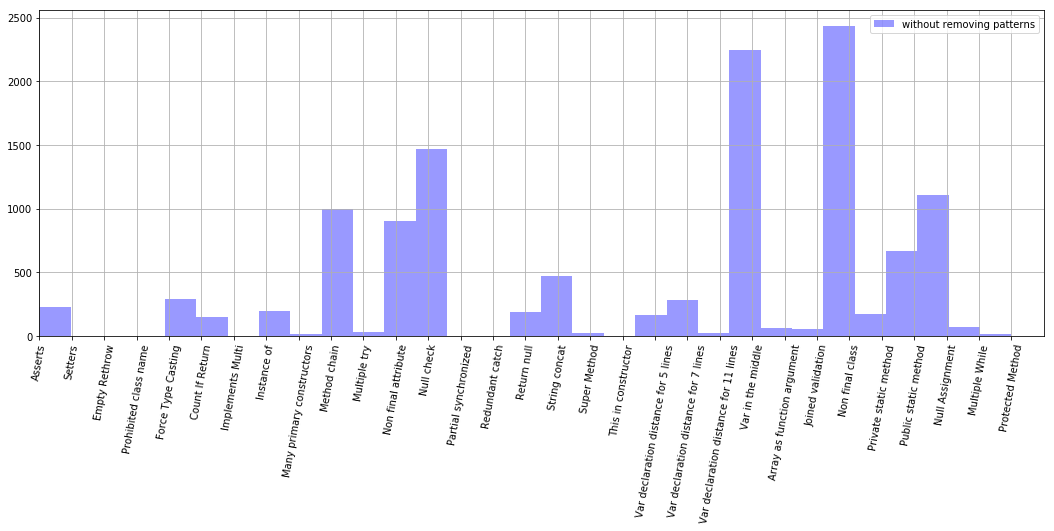

In [26]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='without removing patterns', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 2. removed pattern 'Non final class'

In [135]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.018092245455823743
MAE:  0.09216362208284529
R2:   0.4811413440530158
VAR:   0.034869314115619894


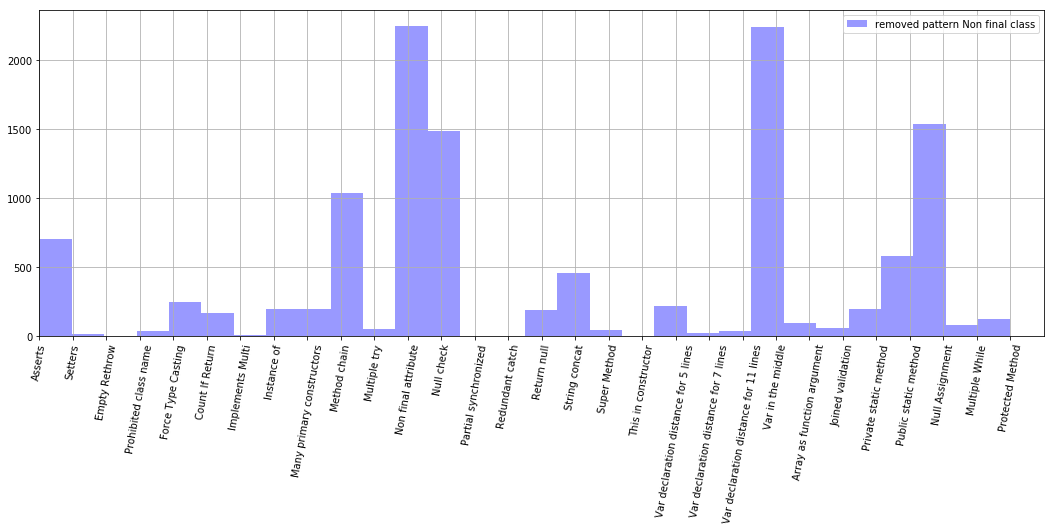

In [136]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed pattern Non final class', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 3. removed pattern 'Var in the middle'

In [38]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.018260974014157695
MAE:  0.09324116918875158
R2:   0.4763024602775999
VAR:   0.034869314115619894


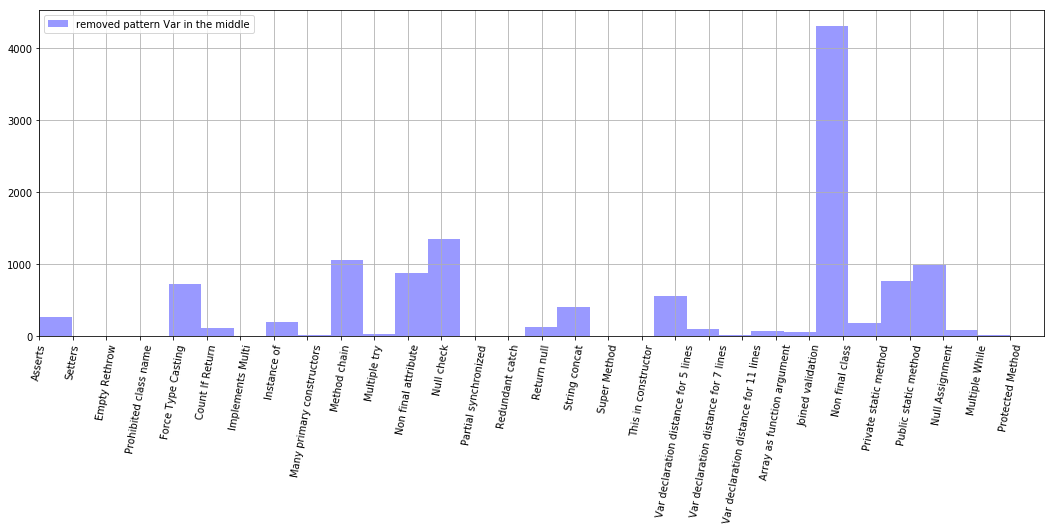

In [39]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed pattern Var in the middle', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 4. removed pattern 'Non final attribute'

In [44]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.019545684129173096
MAE:  0.09927510956467074
R2:   0.4394588874228098
VAR:   0.034869314115619894


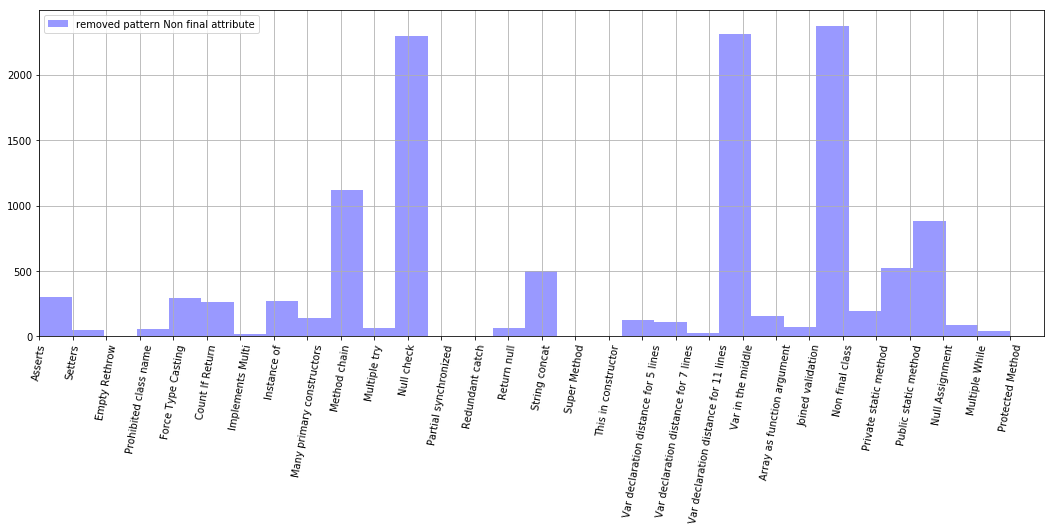

In [45]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed pattern Non final attribute', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 5. removed pattern 'Null check'

In [50]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.02086117997686352
MAE:  0.09996621680938785
R2:   0.4017324256022964
VAR:   0.034869314115619894


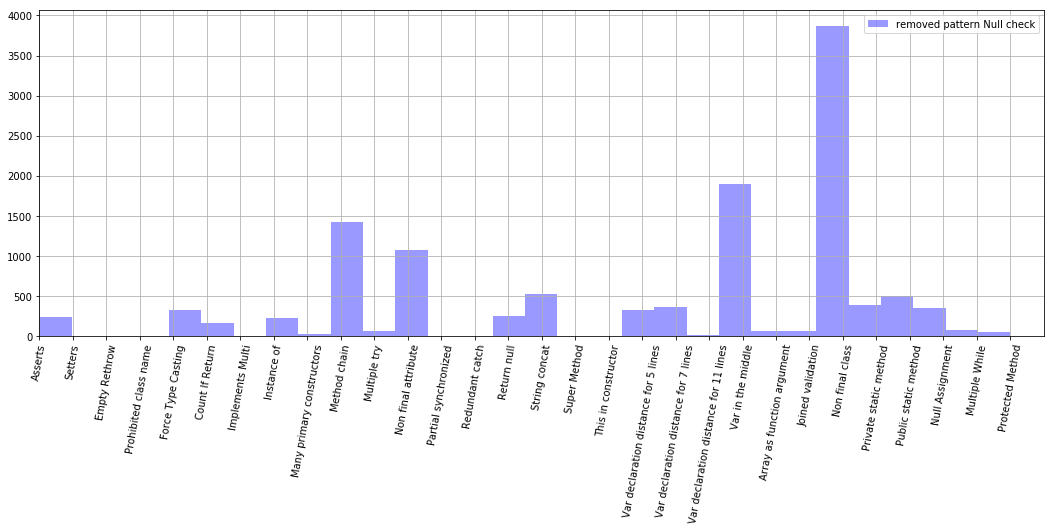

In [51]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed pattern Null check', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 6. removed all 4 patterns

In this experiment we got best distribution of patterns' importances

In [56]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.02371259815995479
MAE:  0.11252327232661688
R2:   0.31995799856204776
VAR:   0.034869314115619894


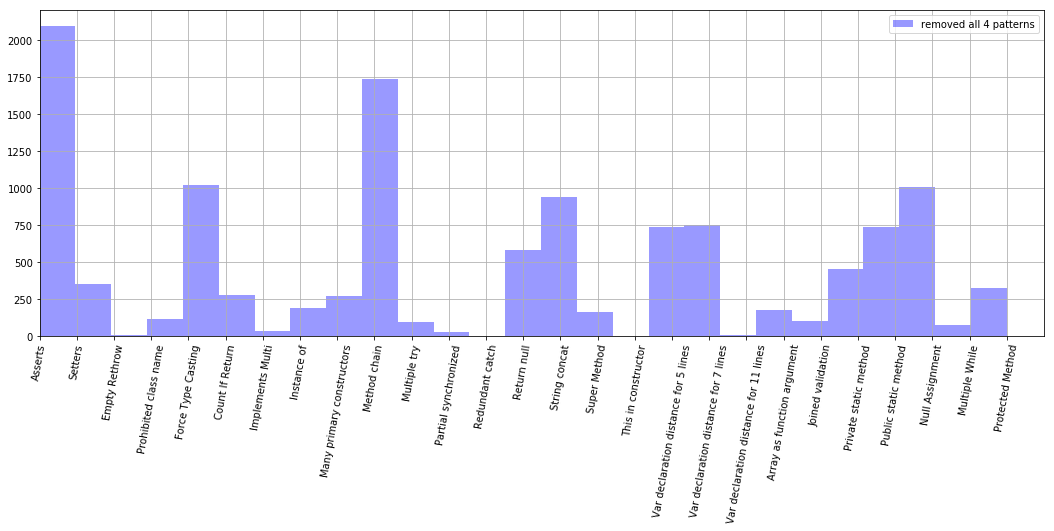

In [57]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed all 4 patterns', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 7. removed patterns 'Non final class' and  'Non final attribute'

In [62]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.01964625409403228
MAE:  0.09933716349462422
R2:   0.4365746906036321
VAR:   0.034869314115619894


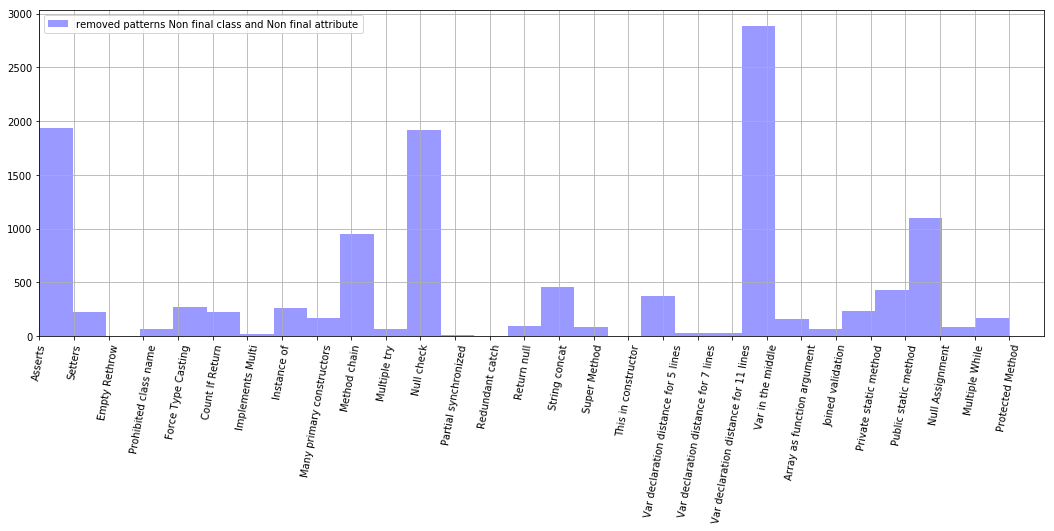

In [63]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed patterns Non final class and Non final attribute', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 8. removed patterns 'Non final class' and 'Null check'

In [68]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.02073854175644146
MAE:  0.09995893677068078
R2:   0.40524950712605157
VAR:   0.034869314115619894


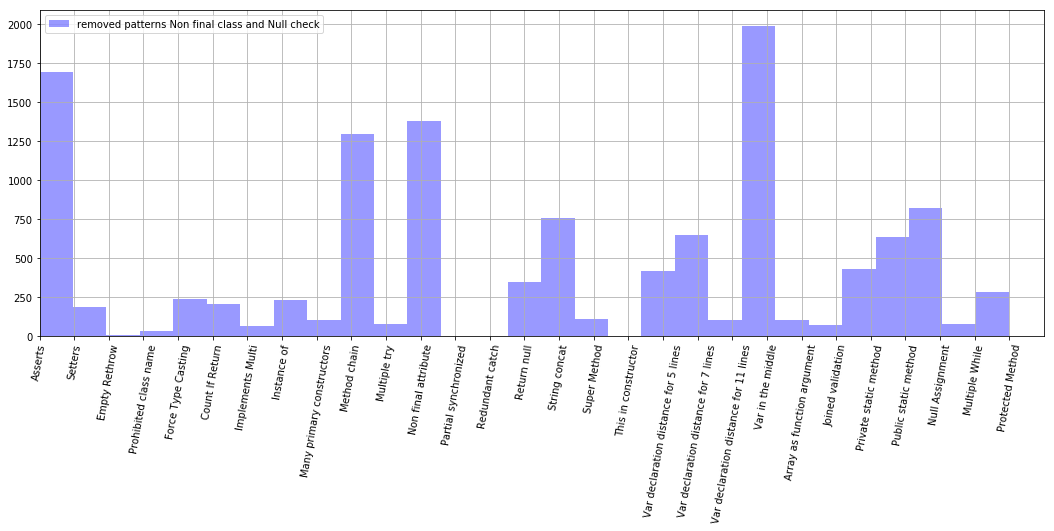

In [69]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed patterns Non final class and Null check', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 9. removed patterns 'Non final class' and 'Var in the middle'

In [74]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.018488737021207714
MAE:  0.09345088141345184
R2:   0.4697705564295689
VAR:   0.034869314115619894


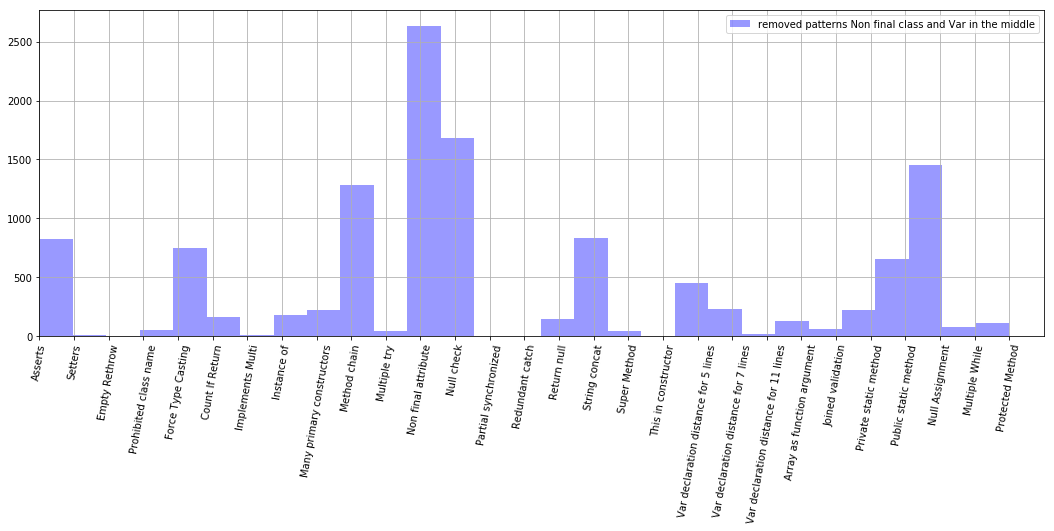

In [75]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed patterns Non final class and Var in the middle', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 10. removed patterns 'Non final attribute' and 'Null check'

In [80]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.022828608152413613
MAE:  0.10845928715465507
R2:   0.3453095155035637
VAR:   0.034869314115619894


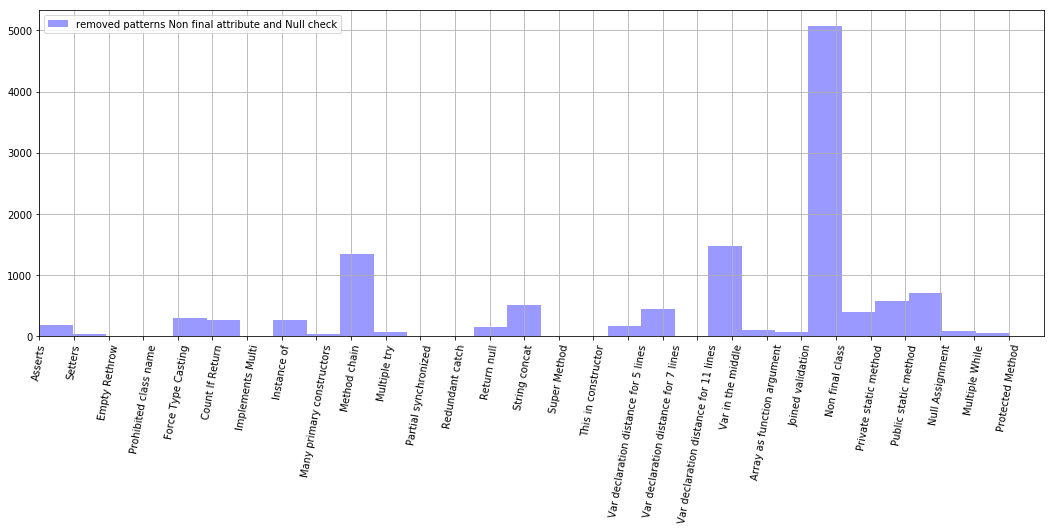

In [81]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed patterns Non final attribute and Null check', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 11. removed patterns 'Non final attribute' and 'Var in the middle'

In [86]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.020019593365628124
MAE:  0.1008729728199166
R2:   0.4258678762866678
VAR:   0.034869314115619894


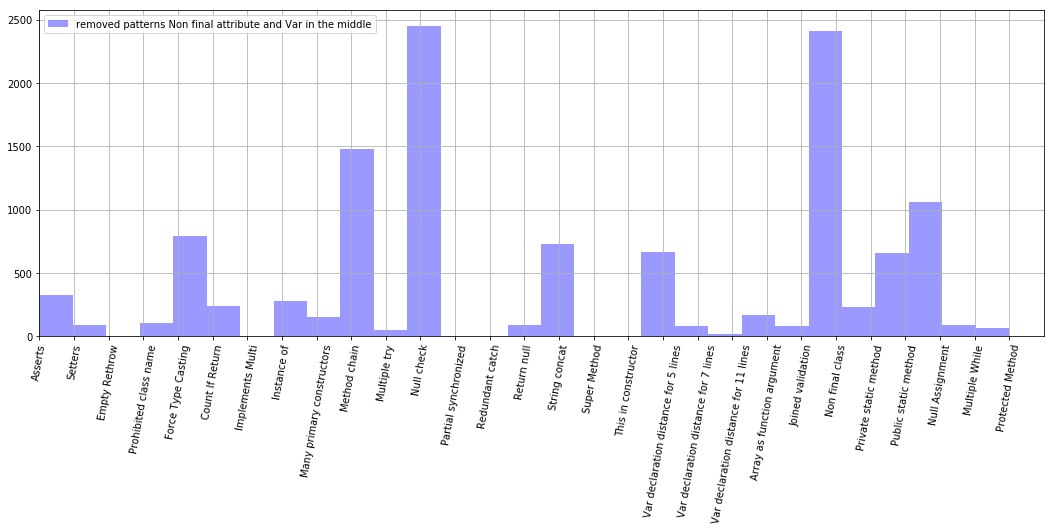

In [87]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed patterns Non final attribute and Var in the middle', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 12. removed patterns 'Null check' and 'Var in the middle'

In [92]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.021296692885277312
MAE:  0.10156306527096576
R2:   0.38924256397296475
VAR:   0.034869314115619894


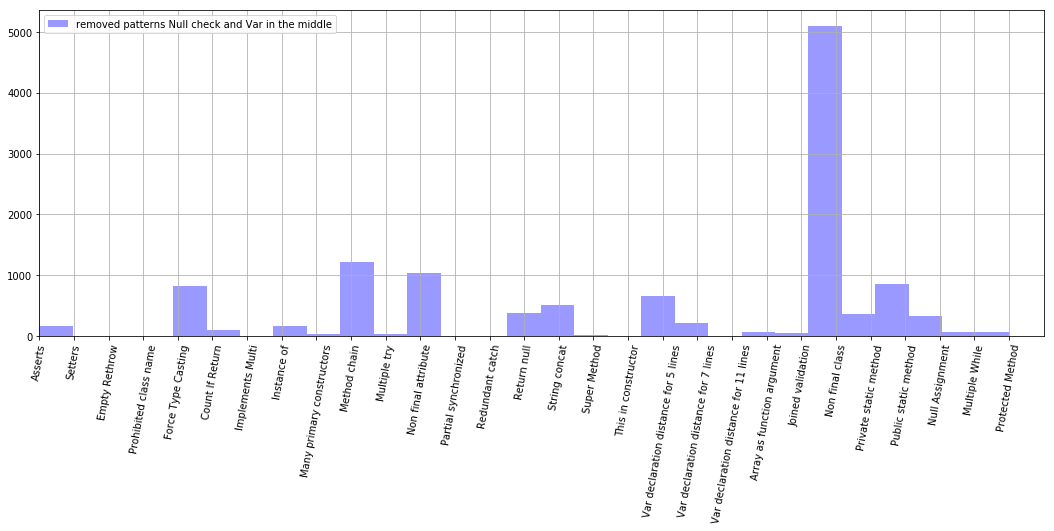

In [93]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed patterns Null check and Var in the middle', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 13. removed patterns 'Non final class', 'Non final attribute' and 'Null check'

In [98]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.02277942965643367
MAE:  0.10869541680611756
R2:   0.3467198815296024
VAR:   0.034869314115619894


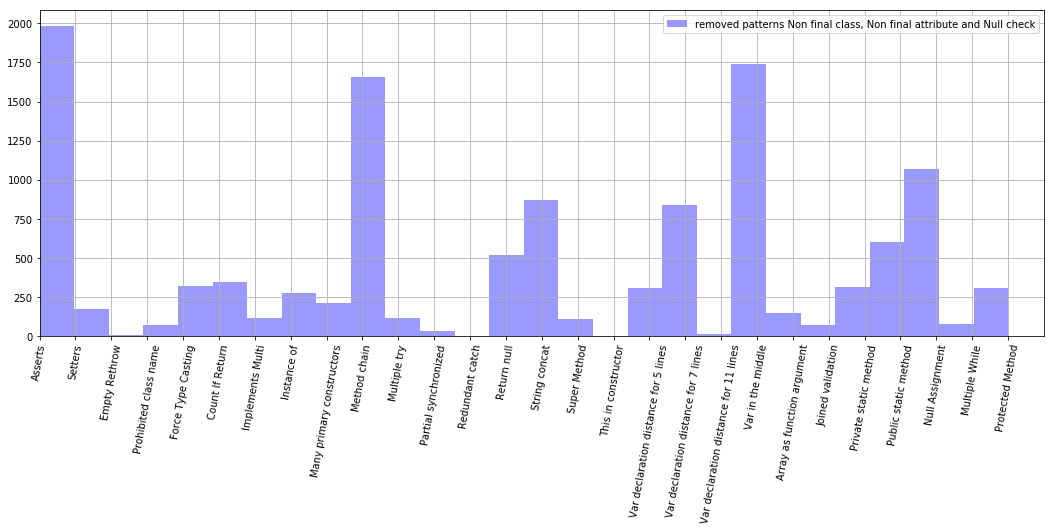

In [99]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed patterns Non final class, Non final attribute and Null check', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 14. removed patterns 'Non final class', 'Non final attribute' and 'Var in the middle'

In [104]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.020000431515902316
MAE:  0.10133371001157215
R2:   0.4264174096001785
VAR:   0.034869314115619894


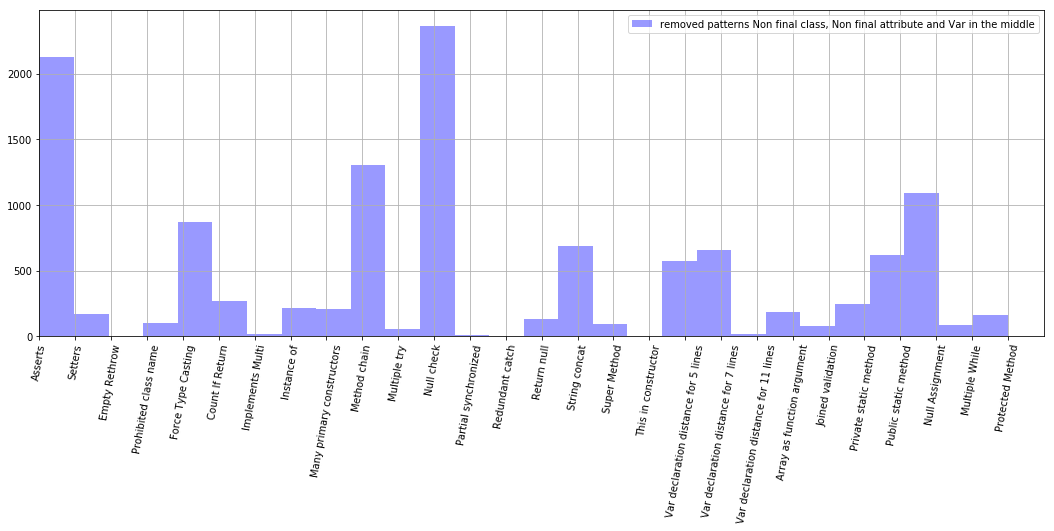

In [105]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed patterns Non final class, Non final attribute and Var in the middle', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 15. removed patterns 'Non final class', 'Null check' and 'Var in the middle'

In [110]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.02135987216502661
MAE:  0.10184835450587146
R2:   0.38743067631897177
VAR:   0.034869314115619894


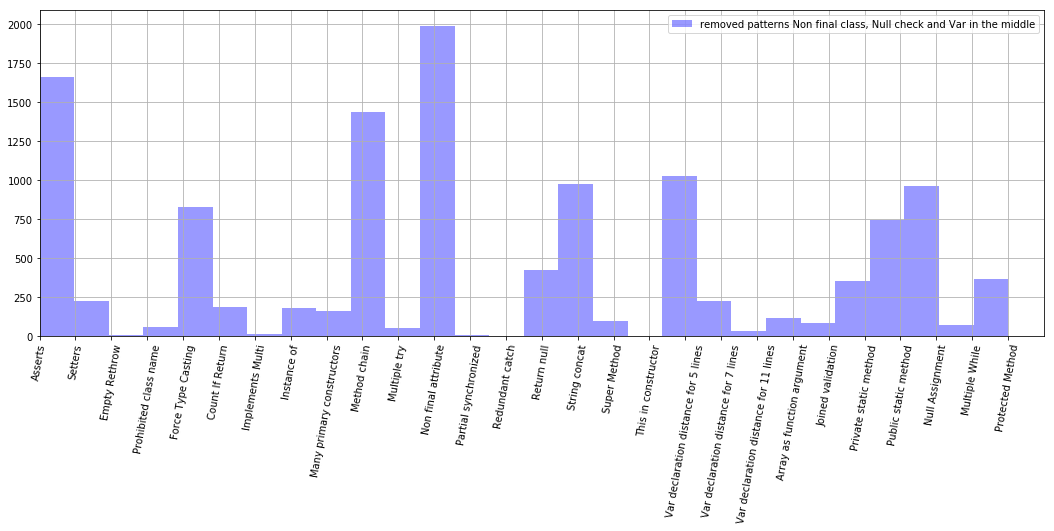

In [111]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed patterns Non final class, Null check and Var in the middle', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

### 16. removed patterns 'Non final attribute', 'Null check' and 'Var in the middle'

In [117]:
print_scores(y4_test, twofold_model1.model.predict(X_test))

MSE:  0.023467125445066166
MAE:  0.11142747840100353
R2:   0.32699779045685495
VAR:   0.034869314115619894


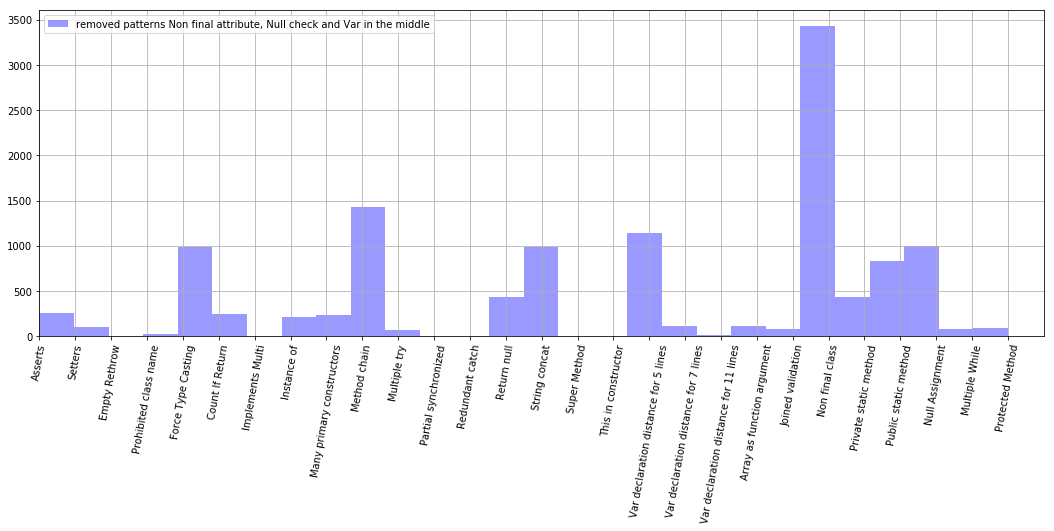

In [118]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='removed patterns Non final attribute, Null check and Var in the middle', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
#sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS1, rotation=80)
plt.legend();

# Results' analysis

New method show good results in prediction of patterns' importances. Importances are more balanced than in previous experiments. This method can be impelemented in our research.

-----------------------------------------